In [1]:
import torch.optim as optim
import torch
import argparse
import numpy as np
import random
import os
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import argparse
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader
import pandas as pd
from probing import *
from utils.general import *
from rdkit import Chem
from rdkit.Chem import Draw

def get_args_parser():
    # Training settings
    # ======= Usually default settings
    parser = argparse.ArgumentParser(description='GNN baselines on ogbgmol* data with Pytorch Geometrics')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--device', type=int, default=0,
                        help='which gpu to use if any (default: 0)')
    parser.add_argument('--drop_ratio', type=float, default=0.5,
                        help='dropout ratio (default: 0.5)')
    parser.add_argument('--batch_size', type=int, default=64,
                        help='input batch size for training (default: 64)')
    parser.add_argument('--num_workers', type=int, default=2,
                        help='number of workers (default: 0)')
    parser.add_argument('--dataset_name', type=str, default="ogbg-molhiv",
                        help='dataset name (default: ogbg-molhiv/moltox21/molpcba)')
    parser.add_argument('--feature', type=str, default="full",
                        help='full feature or simple feature')
    parser.add_argument('--bottle_type', type=str, default='std',
                        help='bottleneck type, can be std or sem')
    # ==== Model Structure ======
        # ----- Backbone
    parser.add_argument('--backbone_type', type=str, default='gcn',
                        help='backbone type, can be gcn, gin, gcn_virtual, gin_virtual')
    parser.add_argument('--emb_dim', type=int, default=300,
                        help='dimensionality of hidden units in GNNs (default: 300)')  
    parser.add_argument('--num_layer', type=int, default=5,
                        help='number of GNN message passing layers (default: 5)')
        # ---- SEM
    parser.add_argument('--L', type=int, default=30,
                        help='No. word in SEM')
    parser.add_argument('--V', type=int, default=10,
                        help='word size in SEM')
                        
        # ---- Head-type
    parser.add_argument('--head_type', type=str, default='linear',
                        help='Head type in interaction, linear or mlp')    
    return parser

def rnd_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        cudnn.benchmark = True

rnd_seed(10086)

args = get_args_parser()
args = args.parse_args(args=[])
#args = args.parse_args()
args.device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
FIG_DIR = 'E:\\P45_disentanglement\\figures\\'

## Prepare for the probing data

In [2]:
if args.dataset_name == 'ogbg-molhiv':
    smiles_path = 'E:\\P4_Graph\\dataset\\ogbg_molhiv\\mapping\\mol.csv.gz'
    args.batch_size = 4113
elif args.dataset_name == 'ogbg-molpcba':
    args.batch_size = 24000
    smiles_path = 'E:\\P4_Graph\\dataset\\ogbg_molpcba\\mapping\\mol.csv.gz'
elif args.dataset_name =='ogbg-moltox21':
    args.batch_size = 783
    smiles_path = 'E:\\P4_Graph\\dataset\\ogbg_moltox21\\mapping\\mol.csv.gz'

selected_prop = ['NumSaturatedRings', 'NumAromaticRings', 'NumAromaticCarbocycles', 'fr_aniline', 
                 'fr_ketone', 'fr_bicyclic', 'fr_methoxy', 'fr_para_hydroxylation', 'fr_pyridine', 'fr_benzene']

dataset = PygGraphPropPredDataset(name = args.dataset_name)
args.num_tasks = dataset.num_tasks
split_idx = dataset.get_idx_split()
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, drop_last=True,
                        num_workers=args.num_workers)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args.batch_size, shuffle=False, drop_last=True,
                        num_workers=args.num_workers)

valid_smiles = pd.read_csv(smiles_path).iloc[split_idx['valid']].smiles.values
valid_smiles = valid_smiles.tolist()
test_smiles = pd.read_csv(smiles_path).iloc[split_idx['test']].smiles.values
test_smiles = test_smiles.tolist()

valid_desc_names, valid_properties = compute_properties(valid_smiles)
test_desc_names, test_properties = compute_properties(test_smiles)

## Prepare the model

In [3]:
# ====== Generate features
def get_features(args, model,loader):
    with torch.no_grad():
        for step, batch in enumerate(loader):
            batch = batch.to(args.device)
            msg, hid = model.task_forward(batch)
        msg = msg.reshape(msg.shape[0],-1)
        return msg.cpu()
    
def model_probing(args, model, run_random=False):
# ====== Generate representations
    embd_valid = get_features(args,model,valid_loader)
    embd_test = get_features(args,model,test_loader)
    performs, rnd_performs = [], []

    for prop in tqdm(selected_prop):
        x_train = embd_valid
        y_train = valid_properties[prop].values[:args.batch_size].copy()
        #y_train[y_train>1] = 1 # binarize
        x_test = embd_test
        y_test = test_properties[prop].values[:args.batch_size].copy()
        #y_test[y_test>1] = 1 # binarize

        performs.append(linear_probing(embedding_train=x_train, y_train=y_train, embeding_test=x_test, 
                                           y_test=y_test, seed=args.seed, scale=True))
        if run_random:
            np.random.shuffle(y_train)
            np.random.shuffle(y_test)
            rnd_performs.append(linear_probing(embedding_train=x_train, y_train=y_train, embeding_test=x_test, 
                                               y_test=y_test, seed=args.seed, scale=True))
        else:
            rnd_performs = performs
    probing_performance = np.array(performs)
    random_performance = np.array(rnd_performs)
    #perf = pd.DataFrame(np.column_stack((probing_performance, random_performance)),
    #                index=selected_prop,
    #                columns=['MAE', 'AUC', 'rnd_MAE', 'rnd_AUC'])
    return probing_performance, random_performance

def get_probing_result(args, ckp_path, run_random=False):
    model = get_init_net(args)
    model.load_state_dict(torch.load(ckp_path),strict=True)
    perf_seed, rnd = model_probing(args, model, run_random=run_random)
    if run_random:
        del model
        return perf_seed, rnd
    else:
        del model
        return perf_seed, perf_seed

def oht_y(y):
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(max_categories=y.max()).fit(y.reshape(-1,1))
    return ohe.transform(y.reshape(-1,1)).toarray()

## Trained on HIV

In [4]:
# ======== Non-SEM model
args.bottle_type = 'std'
args.num_tasks = 1
args.device = torch.device("cpu")
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\ogbg-molhiv'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\ogbg-molhiv\\hiv_gcn_baseline_tab1'
ckp_seed = os.path.join(RESULT_PATH, 'model_seed.pt')
ckp_baseline = os.path.join(RESULT_PATH, 'model_gen_00.pt')

# ======= Init and Baseline
init_base, _ = get_probing_result(args, ckp_seed, run_random=False)
baseline, _ = get_probing_result(args, ckp_baseline, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.10it/s]


In [5]:
# ======= SEM-only and SEM-IL
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\hiv_gcn_semnil_save'
args.bottle_type = 'sem'
args.emb_dim=300
args.L=30
args.V=10
args.num_tasks = 1
ckp_sem_seed = os.path.join(RESULT_PATH, 'model_seed.pt')
init_sem, _ = get_probing_result(args, ckp_sem_seed, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.62it/s]


In [6]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\hiv_gcn_semnil_save'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molhiv\\hiv_gcn_sem_tab1'
args.bottle_type = 'sem'
args.emb_dim=300
args.L=30
args.V=10
args.num_tasks = 1
ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_00.pt')
sem_only, _ = get_probing_result(args, ckp_gen0, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s]


In [7]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\hiv_gcn_semnil_save'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molhiv\\hiv_gcn_semnil_tab1'
args.emb_dim=300
args.L=30
args.V=10
args.num_tasks = 1
ckp_gen9 = os.path.join(RESULT_PATH, 'model_gen_09.pt')
sem_il, _ = get_probing_result(args, ckp_gen9, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.08it/s]


### Train on pcba

In [8]:
# ====== BASELINE ON PCBA
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\pcba_gcn_baseline'
args.bottle_type = 'std'
args.num_tasks = 128
pcba_ckp_baseline = os.path.join(RESULT_PATH, 'model_gen_00.pt')
pcba_baseline, _ = get_probing_result(args, pcba_ckp_baseline, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.00it/s]


In [9]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_semmile_3010_save'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_sem_save'
args.bottle_type = 'sem'
args.head_type = 'linear'
args.num_tasks = 128
#args.L = 40
#args.V = 20
ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_00.pt')
pcba_sem_only, _ = get_probing_result(args, ckp_gen0, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s]


In [10]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_semmile_3010_save'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_semnil_tab2_3010'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_semnil_save'
args.L = 30
args.V = 10
ckp_gen6 = os.path.join(RESULT_PATH, 'model_gen_06.pt')
pcba_sem_il, _ = get_probing_result(args, ckp_gen6, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s]


### Train on 10% pcba

In [11]:
# ====== BASELINE ON PCBA
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\ogbg-molpcba\\pcba_gcn_baseline_subset'
args.bottle_type = 'std'
args.num_tasks = 128
tmp = os.path.join(RESULT_PATH, 'model_gen_00.pt')
subp_baseline, _ = get_probing_result(args, tmp, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


In [12]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_semnil_subset'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_sem_subset'
args.bottle_type = 'sem'
args.head_type = 'linear'
args.num_tasks = 128
#args.L = 40
#args.V = 20
ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_00.pt')
subp_sem_only, _ = get_probing_result(args, ckp_gen0, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.28it/s]


In [21]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_semnil_subset'
args.L = 30
args.V = 10
ckp_gen6 = os.path.join(RESULT_PATH, 'model_gen_05.pt')
subp_sem_il, _ = get_probing_result(args, ckp_gen6, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


### On pcba 1 task

In [26]:
# ====== BASELINE ON PCBA
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\ogbg-molpcba\\pcba_gcn_baseline_subtask'
args.bottle_type = 'std'
args.num_tasks = 1
tmp = os.path.join(RESULT_PATH, 'model_gen_00.pt')
otask_baseline, _ = get_probing_result(args, tmp, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.41it/s]


In [38]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_semnil_subtask'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_sem_subset'
args.bottle_type = 'sem'
args.head_type = 'linear'
args.num_tasks = 1
#args.L = 40
#args.V = 20
ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_00.pt')
otask_sem_only, _ = get_probing_result(args, ckp_gen0, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.28it/s]


In [39]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_semnil_subtask'
#RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\ogbg-molpcba\\pcba_gcn_sem_subset'
args.bottle_type = 'sem'
args.head_type = 'linear'
args.num_tasks = 1
#args.L = 40
#args.V = 20
ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_01.pt')
otask_sem_il, _ = get_probing_result(args, ckp_gen0, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.27it/s]


In [40]:
avg = np.concatenate((init_base, init_sem, baseline ,sem_only,sem_il,pcba_baseline,pcba_sem_only,pcba_sem_il,
                     subp_baseline,subp_sem_only,subp_sem_il,otask_baseline,otask_sem_only,otask_sem_il)).reshape(14,-1).mean(1)

In [41]:
perf_std = pd.DataFrame(np.column_stack((init_base, init_sem, baseline ,sem_only,sem_il,pcba_baseline,pcba_sem_only,pcba_sem_il, 
                                         subp_baseline, subp_sem_only,subp_sem_il,otask_baseline,otask_sem_only,otask_sem_il)),
                      index=selected_prop, columns=['Init. base','Init. SEM', 'Baseline', 'SEM-only', 'SEM-IL','P-Baseline', 'P-SEM-only', 'P-SEM-IL',
                                                    'SP-baseline','SP-SEM-only','SP-SEM-IL','OP-baseline','OP-SEM-only','OP-SEM-IL'])
perf_std = perf_std.T.round(3)
perf_std.loc[:, "avg"] = list(avg.round(3))

In [42]:
perf_std

,NumSaturatedRings,NumAromaticRings,NumAromaticCarbocycles,fr_aniline,fr_ketone,fr_bicyclic,fr_methoxy,fr_para_hydroxylation,fr_pyridine,fr_benzene,avg
Init. base,0.856,0.946,0.787,0.627,0.581,0.617,0.631,0.691,0.642,0.789,0.717
Init. SEM,0.880,0.964,0.826,0.635,0.578,0.626,0.621,0.704,0.665,0.827,0.733
Baseline,0.886,0.955,0.914,0.692,0.715,0.690,0.810,0.749,0.681,0.913,0.800
SEM-only,0.891,0.981,0.936,0.727,0.743,0.772,0.824,0.770,0.768,0.936,0.835
SEM-IL,0.905,0.982,0.967,0.776,0.813,0.786,0.902,0.808,0.856,0.965,0.876
P-Baseline,0.926,0.988,0.970,0.870,0.878,0.834,0.886,0.855,0.851,0.969,0.903
P-SEM-only,0.936,0.990,0.981,0.881,0.920,0.852,0.914,0.881,0.901,0.981,0.924
P-SEM-IL,0.940,0.988,0.981,0.919,0.925,0.859,0.914,0.903,0.902,0.980,0.931
SP-baseline,0.920,0.983,0.960,0.871,0.853,0.826,0.860,0.829,0.852,0.959,0.891
SP-SEM-only,0.943,0.994,0.990,0.878,0.907,0.836,0.921,0.880,0.894,0.990,0.923


In [14]:
perf_std = pd.DataFrame(np.column_stack((pcba_perf_seed, perf_base, perf_seed ,rnd)),
                      index=selected_prop, columns=['pcba-baseline','hiv-baseline', 'initial', 'random'])

In [15]:
perf_std

,pcba-baseline,hiv-baseline,initial,random
NumSaturatedRings,0.652565,0.597374,0.566010,0.403355
NumAromaticRings,0.518843,0.403598,0.391928,0.187941
NumAromaticCarbocycles,0.586190,0.485291,0.397763,0.231218
fr_aniline,0.792123,0.695113,0.646487,0.629711
fr_ketone_Topliss,0.884999,0.814977,0.824945,0.784585
fr_ketone,0.864576,0.753951,0.753221,0.710673
fr_bicyclic,0.480914,0.335278,0.301240,0.232191
fr_methoxy,0.896183,0.831024,0.794311,0.771699
fr_para_hydroxylation,0.823730,0.738147,0.695113,0.659130
fr_pyridine,0.877948,0.838318,0.825918,0.826647


In [ ]:
# ====== BASELINE ON PCBA
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\pcba_gcn_baseline_hid800'
args.num_tasks = 128
args.emb_dim=800
pcba_ckp_baseline = os.path.join(RESULT_PATH, 'model_gen_00.pt')
pcba_perf_seed, _ = get_probing_result(args, pcba_ckp_baseline, run_random=False)
args.emb_dim=300

In [12]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\hiv_gcn_semnil_save'
args.bottle_type = 'sem'
args.emb_dim=300
args.L=30
args.V=10
args.num_tasks = 1
ckp_sem_seed = os.path.join(RESULT_PATH, 'model_seed.pt')
perf_sem_seed, rnd_sem = get_probing_result(args, ckp_sem_seed, run_random=True)

ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_00.pt')
perf_sem_gen0, _ = get_probing_result(args, ckp_gen0, run_random=False)

#ckp_gen1 = os.path.join(RESULT_PATH, 'model_gen_01.pt')
#perf_sem_gen1, _ = get_probing_result(args, ckp_gen0, run_random=False)

#ckp_gen2 = os.path.join(RESULT_PATH, 'model_gen_02.pt')
#perf_sem_gen2, _ = get_probing_result(args, ckp_gen2, run_random=False)

ckp_gen9 = os.path.join(RESULT_PATH, 'model_gen_09.pt')
perf_sem_gen9, _ = get_probing_result(args, ckp_gen9, run_random=False)

 55%|█████████████████████████████████████████████▎                                     | 6/11 [01:10<00:55, 11.17s/it]C:\Users\YIREN\.conda\envs\graph\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\YIREN\.conda\envs\graph\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [01:57<00:10, 10.64s/it]C:\Users\YIREN\.conda\envs\graph\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
  0%|                                     

In [16]:
#perf_sem = pd.DataFrame(np.column_stack((perf_sem_gen9, perf_sem_gen2, perf_sem_gen1, perf_sem_gen0, perf_sem_seed, rnd_sem)),
#                      index=selected_prop, columns=['Gen9', 'Gen2', 'Gen1','SEM-only','SEM-seed','random'])
perf_sem = pd.DataFrame(np.column_stack((perf_sem_gen9, perf_sem_gen0, perf_sem_seed, rnd_sem)),
                      index=selected_prop, columns=['Gen9','SEM-only','SEM-seed','random'])

In [17]:
perf_sem

,Gen9,SEM-only,SEM-seed,random
NumSaturatedRings,0.599076,0.590323,0.554340,0.377097
NumAromaticRings,0.472161,0.480185,0.395332,0.200827
NumAromaticCarbocycles,0.543156,0.525164,0.399708,0.228301
fr_aniline,0.700462,0.688792,0.657428,0.644055
fr_ketone_Topliss,0.826404,0.817165,0.808899,0.775103
fr_ketone,0.800632,0.770484,0.734014,0.687576
fr_bicyclic,0.373936,0.360078,0.303428,0.246049
fr_methoxy,0.862874,0.839047,0.808655,0.786531
fr_para_hydroxylation,0.751033,0.750790,0.709458,0.671529
fr_pyridine,0.859713,0.838318,0.817165,0.830294


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:17<00:00,  7.04s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:07<00:00,  6.11s/it]


In [25]:
#pcba_perf_sem = pd.DataFrame(np.column_stack((pcba_perf_sem_gen6, pcba_perf_sem_gen2, pcba_perf_sem_gen1, pcba_perf_sem_gen0, pcba_perf_sem_seed, rnd_sem)),
#                      index=selected_prop, columns=['Gen6', 'Gen2', 'Gen1','SEM-only','SEM-seed','random'])
pcba_perf_sem = pd.DataFrame(np.column_stack((pcba_perf_sem_gen6, pcba_perf_sem_gen0, pcba_perf_sem_seed, rnd_sem)),
                      index=selected_prop, columns=['Gen6','SEM-only','SEM-seed','random'])

In [26]:
pcba_perf_sem

,Gen6,Gen4,SEM-only,SEM-seed,random
NumSaturatedRings,0.648189,0.672988,0.671043,0.580598,0.404814
NumAromaticRings,0.543399,0.560175,0.541940,0.409677,0.202285
NumAromaticCarbocycles,0.624605,0.635789,0.621687,0.405057,0.238755
fr_aniline,0.794311,0.793338,0.795526,0.664965,0.641867
fr_ketone_Topliss,0.886701,0.881109,0.878434,0.819840,0.803307
fr_ketone,0.863846,0.870168,0.864819,0.754680,0.739120
fr_bicyclic,0.445660,0.446876,0.466813,0.293946,0.248237
fr_methoxy,0.883297,0.884513,0.867250,0.795770,0.779480
fr_para_hydroxylation,0.816679,0.814004,0.813761,0.707027,0.687819
fr_pyridine,0.896912,0.901532,0.892050,0.824216,0.835886


In [18]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\pcqm_gcn_semnil_save'
args.bottle_type = 'sem'
args.emb_dim = 600
args.L = 40
args.V = 20
args.head_type = 'linear'
args.num_tasks = 1

ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_00.pt')
pcqm_perf_sem_gen0, _ = get_probing_result(args, ckp_gen0, run_random=False)

ckp_gen4 = os.path.join(RESULT_PATH, 'model_gen_04.pt')
pcqm_perf_sem_gen4, _ = get_probing_result(args, ckp_gen4, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.31s/it]


In [21]:
pcba_perf_sem = pd.DataFrame(np.column_stack((pcqm_perf_sem_gen4,pcqm_perf_sem_gen0)),
                      index=selected_prop, columns=['Gen4','SEM-only'])

In [22]:
pcba_perf_sem

,Gen4,SEM-only
NumSaturatedRings,0.601994,0.596888
NumAromaticRings,0.425723,0.424751
NumAromaticCarbocycles,0.450766,0.451495
fr_aniline,0.719669,0.727206
fr_ketone,0.827377,0.823487
fr_bicyclic,0.355458,0.339898
fr_methoxy,0.826647,0.821541
fr_para_hydroxylation,0.748602,0.740579
fr_pyridine,0.845855,0.837588
fr_benzene,0.450280,0.445903


# Find Pattern in Z

In [4]:
def chem_show(idx):
    tmp = valid_smiles[idx]
    tmp_g = Chem.MolFromSmiles(tmp)
    mol_img = Draw.MolToImage(tmp_g,size=(400,400))
    mol_img = np.asarray(mol_img)
    return mol_img
#plt.imshow(chem_show(0))
def find_distance(msg,idx_anchor,dis_type='edit'):
    anchor = msg[idx_anchor]
    dist_list = []
    for i in range(4113):
        if dis_type=='edit':
            dist_list.append((anchor == msg[i]).sum().item())
        elif dis_type=='mse':
            dist_list.append(-torch.norm(anchor-msg[i]).item())
        elif dis_type=='cosine':
            dist_list.append(torch.nn.CosineSimilarity(dim=0)(anchor.unsqueeze(-1),msg[i].unsqueeze(-1)).item())
    dist_index = np.argsort(dist_list)[::-1]
    return dist_index, dist_list

In [5]:
"""
model_seed = get_init_net(args)
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\pcba_gcn_baseline'
args.bottle_type = 'std'
args.head_type = 'linear'
args.num_tasks = 128
ckp_path = os.path.join(RESULT_PATH, 'model_gen_00.pt')
model_semnil = get_init_net(args)
model_semnil.load_state_dict(torch.load(ckp_path),strict=True)


model_seed = get_init_net(args)
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\pcba_gcn_semnil_save'
args.bottle_type = 'sem'
args.L = 40
args.V = 20
args.head_type = 'linear'
args.num_tasks = 128
ckp_path = os.path.join(RESULT_PATH, 'model_seed.pt')
model_semnil = get_init_net(args)
model_semnil.load_state_dict(torch.load(ckp_path),strict=True)



model_seed = get_init_net(args)
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\ogbg-molhiv'
args.bottle_type = 'std'
args.L = 30
args.V = 10
args.head_type = 'linear'
args.num_tasks = 1
ckp_path = os.path.join(RESULT_PATH, 'model_gen_00.pt')
model_semnil = get_init_net(args)
model_semnil.load_state_dict(torch.load(ckp_path),strict=True)


model_seed = get_init_net(args)
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\hiv_gcn_semnil_save'
args.bottle_type = 'sem'
args.L = 30
args.V = 10
args.head_type = 'linear'
args.num_tasks = 1
ckp_path = os.path.join(RESULT_PATH, 'model_gen_06.pt')
model_semnil = get_init_net(args)
model_semnil.load_state_dict(torch.load(ckp_path),strict=True)
"""

"\nmodel_seed = get_init_net(args)\nRESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\pcba_gcn_baseline'\nargs.bottle_type = 'std'\nargs.head_type = 'linear'\nargs.num_tasks = 128\nckp_path = os.path.join(RESULT_PATH, 'model_gen_00.pt')\nmodel_semnil = get_init_net(args)\nmodel_semnil.load_state_dict(torch.load(ckp_path),strict=True)\n\n\nmodel_seed = get_init_net(args)\nRESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\pcba_gcn_semnil_save'\nargs.bottle_type = 'sem'\nargs.L = 40\nargs.V = 20\nargs.head_type = 'linear'\nargs.num_tasks = 128\nckp_path = os.path.join(RESULT_PATH, 'model_seed.pt')\nmodel_semnil = get_init_net(args)\nmodel_semnil.load_state_dict(torch.load(ckp_path),strict=True)\n\n\n\nmodel_seed = get_init_net(args)\nRESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\ogbg-molhiv'\nargs.bottle_type = 'std'\nargs.L = 30\nargs.V = 10\nargs.head_type = 'linear'\nargs.num_tasks = 1\nckp_path = os.path.join(RESULT_PATH, 'model_gen_00.pt')\nmodel_semnil = get_init_net(args)\nmodel_semnil.

In [6]:
model_seed = get_init_net(args)
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\pcba_gcn_semnil_save'
args.bottle_type = 'sem'
args.L = 40
args.V = 20
args.head_type = 'linear'
args.num_tasks = 128
ckp_path = os.path.join(RESULT_PATH, 'model_seed.pt')
model_semnil = get_init_net(args)
model_semnil.load_state_dict(torch.load(ckp_path),strict=True)

<All keys matched successfully>

In [7]:
for step, batch in enumerate(valid_loader):
    batch = batch.to(args.device)
    break
msg,hid = model_semnil.task_forward(batch)
if args.bottle_type=='sem':
    msg = msg.argmax(-1)
msg = msg.detach().cpu()

In [8]:
#OBSERVE_LIST = [4112, 1997, 1977, 1974, 1991,2273,2281,2458]
OBSERVE_LIST = [2273, 2459, 2285, 2267,2505, 4112,1977,2281]
DIST_SEL = [0, 1, 20]

In [9]:
"""
ALL_DISTANCE = np.zeros((4113,4113))
for i in range(4113):
    for j in range(i):
        ALL_DISTANCE[i][j]=-torch.norm(anchor-msg[i]).item()
"""

'\nALL_DISTANCE = np.zeros((4113,4113))\nfor i in range(4113):\n    for j in range(i):\n        ALL_DISTANCE[i][j]=-torch.norm(anchor-msg[i]).item()\n'

In [10]:
# dist 37: [2273, 2281, 2458]
# dist 36: [1995, 2283, 2285, 2294]
# dist 35: [203, 2034, 2112, 2267, 2267, 2271, 2281, 2283, 2285, 2302, 2459, 2505, 3662]

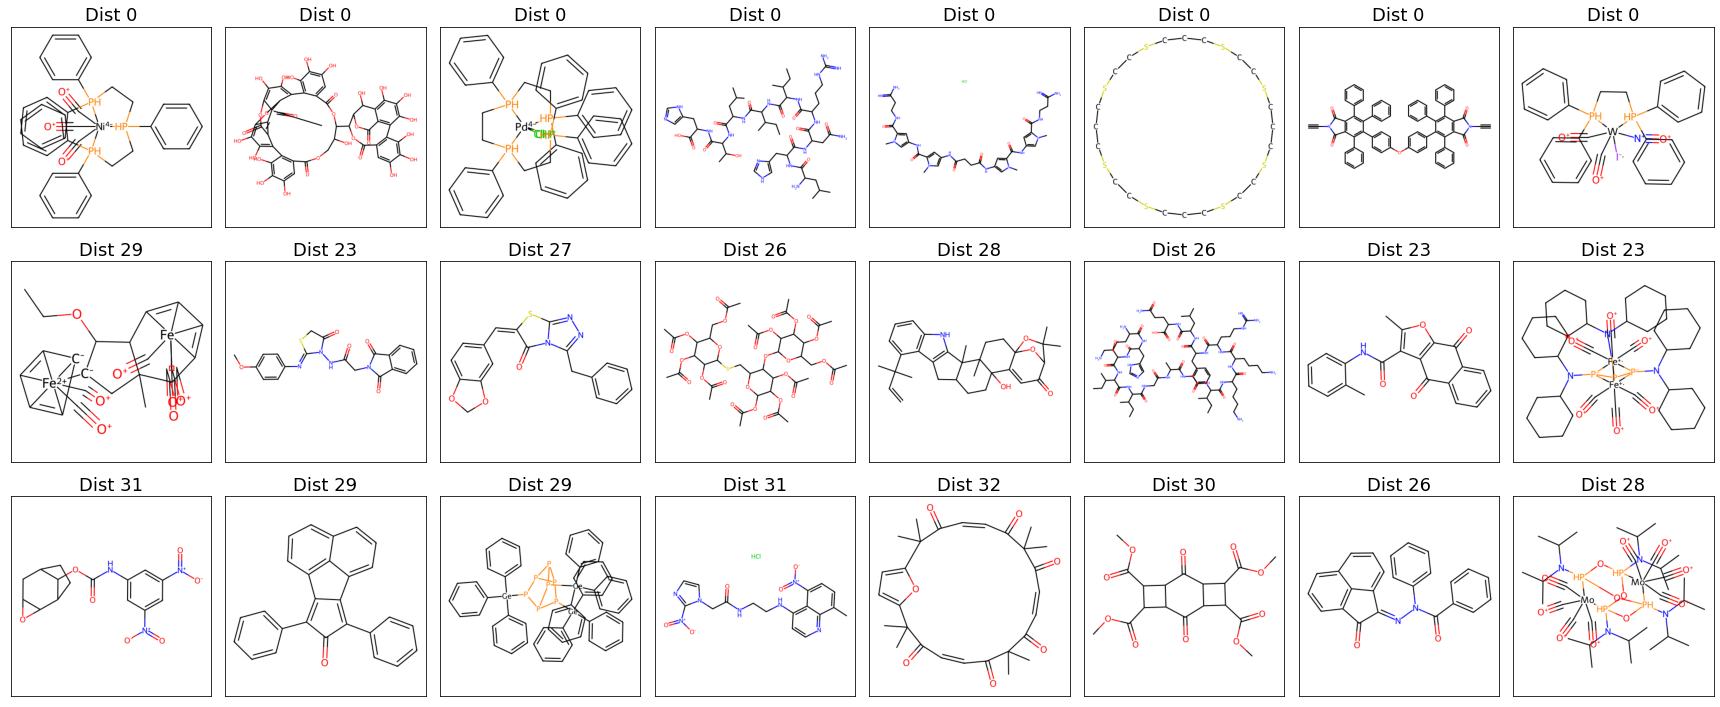

In [11]:
f, ax = plt.subplots(3,8,figsize=(24, 10))
for i in range(len(OBSERVE_LIST)):
    obs = OBSERVE_LIST[i]
    dist_index, dist_list = find_distance(msg,obs,dis_type='edit')
    for j in range(3):
        jj = DIST_SEL[j]
        mol_idx = dist_index[jj]
        distance = dist_list[mol_idx]
        ax[j][i].set_title("Dist "+str(40-distance),fontsize=18)
        tmp_img = chem_show(mol_idx)
        ax[j][i].imshow(tmp_img)
        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])        
plt.tight_layout()
plt.savefig(FIG_DIR + 'show_mol_before.pdf')

In [12]:
(0.4095-0.1389)/0.4095

0.6608058608058607

In [10]:
ANCHOR = 1991
anchor = msg[ANCHOR]
dist_list = []
for i in range(4113):
    dist_list.append((anchor == msg[i]).sum())
    #dist_list.append(-torch.norm(anchor-msg[i]).item())
    #dist_list.append(torch.nn.CosineSimilarity(dim=0)(anchor.unsqueeze(-1),msg[i].unsqueeze(-1)))
dist_index = np.argsort(dist_list)[::-1]

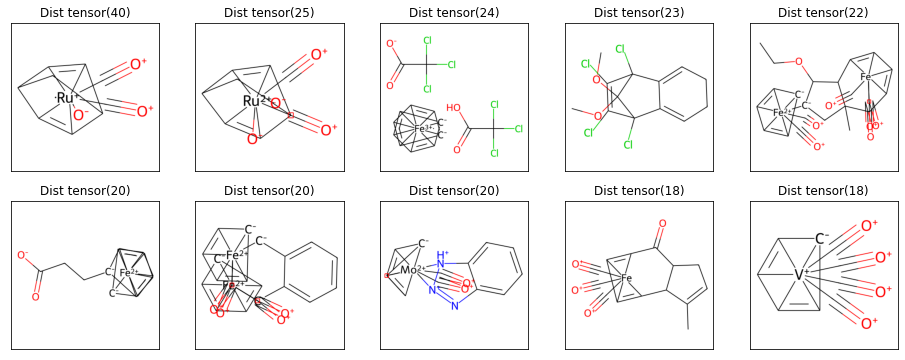

In [11]:
f, ax = plt.subplots(2,5,figsize=(16, 6))
for ii in range(2):
    for jj in range(5):
        i = jj+ii*5
        mol_idx = dist_index[i]
        distance = dist_list[mol_idx]
        ax[ii][jj].set_title("Dist "+str(distance))
        tmp_img = chem_show(mol_idx)
        ax[ii][jj].imshow(tmp_img)
        ax[ii][jj].set_xticks([])
        ax[ii][jj].set_yticks([])

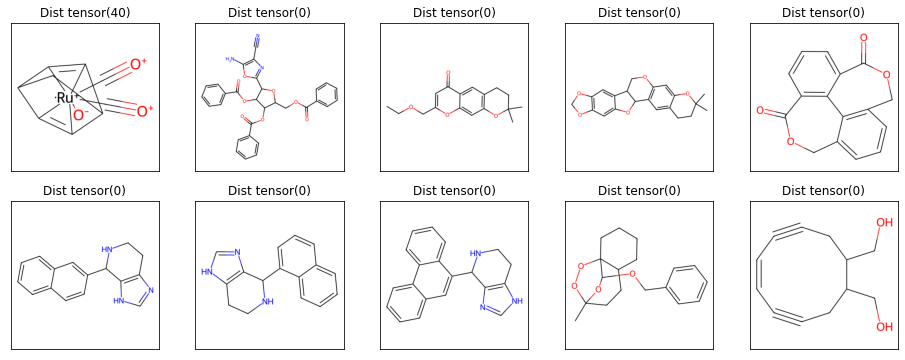

In [12]:
f, ax = plt.subplots(2,5,figsize=(16, 6))
for ii in range(2):
    for jj in range(5):
        i = jj+ii*5
        mol_idx = dist_index[-i]
        distance = dist_list[mol_idx]
        ax[ii][jj].set_title("Dist "+str(distance))
        tmp_img = chem_show(mol_idx)
        ax[ii][jj].imshow(tmp_img)
        ax[ii][jj].set_xticks([])
        ax[ii][jj].set_yticks([])

In [12]:
dist_index[-7]

1805

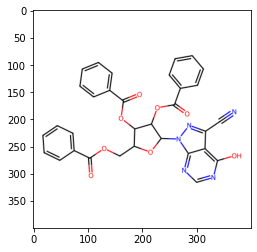

In [17]:
tmp_img = chem_show(5)
plt.imshow(tmp_img)